
<div style="text-align: center;">
    <h1>ReConPatch: anomaly detection</h1>
    <h3>Authors:</h3>
    <p>Dario Loi 1940849, Elena Muia 1938610, Martina Doku 1938629</p>

</div>


<div>
    <h2>0 - Introduction</h2>
    <p>This project aims to reimplement and potentially advance the ReConPatch method proposed in the paper titled  <a href="https://arxiv.org/pdf/2305.16713v3">”ReConPatch:
Anomaly Detection by Linear Modulation of Pretrained Features.”</a> This method addresses the challenge of
anomaly detection by constructing discriminative features through a linear modulation of patch features extracted
from pre-trained models and employs contrastive representation learning to collect and distribute features in a way
that produces a target-oriented and easily separable representation of the data.</p>
</div>


In [1]:
import glob
import os
import random
from PIL import Image
from typing import Optional

import lightning.pytorch as pl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from adamp import AdamP
from ema_pytorch import EMA
from lightning import LightningDataModule, LightningModule
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger
from sklearn import random_projection
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import wandb
from enum import Enum

<div>
    <h2>1.1 - Data</h2>
    <p>In this study, we used the <a href="https://arxiv.org/pdf/2305.16713v3">MVTec AD</a> dataset
and <a href="https://arxiv.org/pdf/2305.16713v3">BTAD</a> dataset for our experiments</p>
</div>


In [2]:
# data
# !wget https://www.mvtec.com/company/research/datasets/mvtec-ad/downloads/mvtec_anomaly_detection.tar.xz

In [3]:
class MVTecADDataset(Dataset):
    def __init__(self, root_dir, phase, image_transform=None, mask_transform=None):
        self.root_dir = root_dir
        self.phase = phase
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.data = []
        self.masks = {}

        if self.phase == "train":
            self._load_train_data()
        else:
            self._load_test_data()

    def _load_train_data(self):
        for subclass in [
            "bottle",
            "cable",
            "capsule",
            "carpet",
            "grid",
            "hazelnut",
            "leather",
            "metal_nut",
            "pill",
            "screw",
            "tile",
            "toothbrush",
            "transistor",
            "wood",
            "zipper",
        ]:
            train_dir = os.path.join(self.root_dir, subclass, "train", "good")
            image_paths = glob.glob(os.path.join(train_dir, "*.png"))

            for image_path in image_paths:
                self.data.append((image_path, 0))

    def _load_test_data(self):
        for subclass in [
            "bottle",
            "cable",
            "capsule",
            "carpet",
            "grid",
            "hazelnut",
            "leather",
            "metal_nut",
            "pill",
            "screw",
            "tile",
            "toothbrush",
            "transistor",
            "wood",
            "zipper",
        ]:
            test_dir = os.path.join(self.root_dir, subclass, "test")
            mask_dir = os.path.join(self.root_dir, subclass, "ground_truth")
            categories = os.listdir(test_dir)

            for category in categories:
                category_dir = os.path.join(test_dir, category)
                if category == "good":
                    image_paths = glob.glob(os.path.join(category_dir, "*.png"))
                    for image_path in image_paths:
                        self.data.append((image_path, 0))
                else:
                    image_paths = glob.glob(os.path.join(category_dir, "*.png"))
                    for image_path in image_paths:
                        self.data.append((image_path, 1))
                        mask_path = os.path.join(
                            mask_dir,
                            category,
                            os.path.basename(image_path).replace(".png", "_mask.png"),
                        )
                        self.masks[image_path] = mask_path

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert("RGB")

        if self.image_transform:
            image = self.image_transform(image)

        if label == 1 and self.phase == "test":
            mask_path = self.masks[image_path]
            mask = Image.open(mask_path).convert("L")
            if self.mask_transform:
                mask = self.mask_transform(mask)
            return image, label, mask

        return image, label


def custom_collate_fn(batch):
    images = []
    labels = []
    masks = []

    for item in batch:
        images.append(item[0])
        labels.append(item[1])
        if len(item) == 3:
            masks.append(item[2])

    images = torch.stack(images)
    labels = torch.tensor(labels)

    if masks:
        masks = torch.stack(masks)
        return images, labels, masks
    return images, labels


class MVTecDataModule(LightningDataModule):
    def __init__(
        self,
        root_dir,
        batch_size=32,
        image_transform=None,
        mask_transform=None,
        custom_collate_fn=None,
    ):
        super().__init__()
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def setup(self, stage=None):
        full_train_dataset = MVTecADDataset(
            self.root_dir,
            phase="train",
            image_transform=self.image_transform,
            mask_transform=self.mask_transform,
        )

        # Split the dataset
        train_size = int(0.8 * len(full_train_dataset))
        val_size = len(full_train_dataset) - train_size
        self.train_dataset, self.val_dataset = torch.utils.data.random_split(
            full_train_dataset, [train_size, val_size]
        )

        self.test_dataset = MVTecADDataset(
            self.root_dir,
            phase="test",
            image_transform=self.image_transform,
            mask_transform=self.mask_transform,
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=custom_collate_fn,
            num_workers=4,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=custom_collate_fn,
            num_workers=4,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=custom_collate_fn,
            num_workers=4,
        )

    def show_examples(self, dataloader, title):

        # Get a batch of samples
        images, labels = next(iter(dataloader))
        # Select one sample from the batch
        image = images[0]
        # Convert the tensor to a numpy array for displaying
        image = image.permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.title(f"{title}")
        plt.show()

    def show_random_images(self, dataloader, title, num_images=10):
        fig, axs = plt.subplots(2, num_images, figsize=(20, 8))
        axs = axs.flatten()

        # Randomly select images from the dataloader
        selected_indices = random.sample(range(len(dataloader.dataset)), num_images)

        for i, idx in enumerate(selected_indices):
            sample = dataloader.dataset[idx]
            if isinstance(sample, tuple) and len(sample) == 3:
                image, label, mask = sample
            else:
                image, label = sample
                mask = None

            # Ensure the image is a tensor
            if isinstance(image, Image.Image):
                image = transforms.ToTensor()(image)
            if mask is not None and isinstance(mask, Image.Image):
                mask = transforms.ToTensor()(mask)

            image = image.permute(1, 2, 0).numpy()
            axs[2 * i].imshow(image)
            axs[2 * i].set_title(f"{title} - Label: {label}")
            axs[2 * i].axis("off")

            if mask is not None and len(mask) > 0:
                mask = mask.permute(1, 2, 0).numpy()
                axs[2 * i + 1].imshow(mask, cmap="gray")
                axs[2 * i + 1].set_title(f"{title} - Mask")
                axs[2 * i + 1].axis("off")
            else:
                axs[2 * i + 1].axis("off")

        plt.tight_layout()
        plt.show()

In [4]:
# Define transforms to ensure consistent image sizes
image_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # Resize all images to the same size
        transforms.ToTensor(),
    ]
)

mask_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # Resize all masks to the same size
        transforms.ToTensor(),
    ]
)

In [5]:
"""
for sample in tqdm(test_loader):
    if len(sample) == 3:
        img, label, mask = sample
        print(f"Image shape: {img.shape}, Label: {label.shape}, Mask shape: {mask.shape}")
    else:
        img, label = sample
        print(f"Image shape: {img.shape}, Label: {label.shape}")
"""

'\nfor sample in tqdm(test_loader):\n    if len(sample) == 3:\n        img, label, mask = sample\n        print(f"Image shape: {img.shape}, Label: {label.shape}, Mask shape: {mask.shape}")\n    else:\n        img, label = sample\n        print(f"Image shape: {img.shape}, Label: {label.shape}")\n'

## EMA Custom Impl

In [6]:
class EMA_linear(nn.Module):
    """EMA_linear

    Exponential Moving Average Linear Layer

    This layer is used to store a non-trainable version of the weights and biases of
    another layer, so that it can act as a target layer for a twin layer that is actually
    being optimized. The weights and biases of this layer are updated with an exponential
    moving average upon calling the `update` method. The update is performed every `steps_to_update`
    """

    def __init__(
        self,
        in_features,
        out_features,
        alpha=0.999,
        negative_slope=1e-3,
        steps_to_update=1,
    ):
        """__init__ EMA_linear

        Parameters
        ----------
        in_features : int
            Number of input features
        out_features : int
            int
        alpha : float, optional
            EMA smoothing coefficient, by default 0.999
        negative_slope : int, optional
            leaky_ReLU negative slope used to initialize the weights, by default 1e-3
        steps_to_update : int, optional
            steps before an actual update is performed, by default 1
        """
        super(EMA_linear, self).__init__()

        assert 0.0 <= alpha <= 1.0, f"Invalid alpha: {alpha}"
        assert steps_to_update > 0, f"Invalid steps_to_update: {steps_to_update}"

        self.alpha = alpha
        self.in_features = in_features
        self.out_features = out_features
        self.steps_to_update = steps_to_update
        self._step = 0
        self.negative_slope = negative_slope
        self.register_buffer("weight", torch.zeros(out_features, in_features))
        self.register_buffer("bias", torch.zeros(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_normal_(self.weight, a=self.negative_slope)
        nn.init.constant_(self.bias, 0)

    def set_parameters(self, weight, bias):
        """set_parameters

        Parameters
        ----------
        weight : torch.Tensor
            weight tensor
        bias : torch.Tensor
            bias tensor
        """
        with torch.no_grad():
            self.weight.copy_(weight)
            self.bias.copy_(bias)

    def forward(self, input):
        """forward

        MX + b, that's all

        Parameters
        ----------
        input : torch.Tensor
            input tensor

        Returns
        -------
        torch.Tensor
            output tensor
        """
        return F.linear(input, self.weight, self.bias)

    def update(self, weight, bias):
        """update

        Parameters
        ----------
        weight : torch.Parameter
            weight tensor
        bias : torch.Parameter
            bias tensor
        """

        self._step += 1

        if self._step % self.steps_to_update != 0:
            return

        with torch.no_grad():
            self.weight.copy_(self.alpha * self.weight + (1 - self.alpha) * weight)
            self.bias.copy_(self.alpha * self.bias + (1 - self.alpha) * bias)
        self._step = 0

    def extra_repr(self):
        return "in_features={}, out_features={}, alpha={}".format(
            self.in_features, self.out_features, self.alpha
        )

## Losses

In [7]:
# We set \sigma = 1 based on the cited papers 18 and 19 in ReConPatch
class ContextualSimilarity(nn.Module):
    def __init__(self, k=5, alpha=0.5):
        super(ContextualSimilarity, self).__init__()
        self.k = k
        self.alpha = alpha

    def forward(self, z):
        distances = torch.cdist(z, z)
        topk_dist = -torch.topk(-distances, self.k)[0][:, -1]
        filtering = (distances <= topk_dist.unsqueeze(-1)).float()
        similarity = torch.matmul(filtering, filtering.transpose(0, 1)) / torch.sum(
            filtering, dim=-1, keepdim=True
        )
        R = filtering * filtering.transpose(0, 1)
        similarity = torch.matmul(similarity, R.transpose(0, 1)) / torch.sum(
            R, dim=-1, keepdim=True
        )
        return self.alpha * (similarity + similarity.transpose(0, 1))


class PairwiseSimilarity(nn.Module):
    def __init__(self, sigma=1.0):
        super(PairwiseSimilarity, self).__init__()
        self.sigma = sigma

    def forward(self, z):
        return torch.exp(-(torch.cdist(z, z) / self.sigma))


def relaxedContrastiveLoss(w, delta, m):
    return torch.mean(
        w * delta**2 + (1 - w) * torch.max(m - delta, torch.tensor(0.0)) ** 2
    )


class RelaxedContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super(RelaxedContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, w, delta):
        return torch.mean(
            w * delta**2
            + (1 - w) * torch.max(self.margin - delta, torch.tensor(0.0)) ** 2
        )

## Model

In [48]:
class MemoryState(Enum):

    EMPTY = 0
    FILLED = 1
    PRUNED = 2


class MemBank:

    def __init__(self, eps=0.75, coreset_size=1000):
        """__init__ MemBank

        Parameters
        ----------
        eps : float, optional
            quality parameter to tune the SparseRandomProjection dimensionality reductor, by default 0.75
        coreset_size : int, optional
            size of the coreset, by default 1000
        """

        self.buffer = []
        self.state = MemoryState.EMPTY
        self.projector = random_projection.SparseRandomProjection(eps=eps)

        self.coreset_size = coreset_size

    def obtain_coreset(self):

        if self.state != MemoryState.FILLED:
            raise ValueError("Memory bank is not filled, can't prune for coreset")

        with torch.no_grad():

            buf = self.buffer.detach().cpu().numpy()
            buf_proj = torch.tensor(self.projector.fit_transform(buf))

            last_val = buf_proj[0]
            coreset_indices = [0]

            min_distances = torch.linalg.norm(buf_proj - last_val, dim=1, keepdims=True)

            for _ in tqdm(range(self.coreset_size - 1)):
                distances = torch.linalg.norm(buf_proj - last_val, dim=1, keepdims=True)
                min_distances = torch.minimum(distances, min_distances)
                index = torch.argmax(min_distances).item()
                last_val = buf_proj[index]
                min_distances[index] = 0
                coreset_indices.append(index)

            coreset = buf_proj[coreset_indices]

            self.buffer = coreset
            self.state = MemoryState.PRUNED

    def project(self, X):

        if self.state != MemoryState.PRUNED:
            raise ValueError(
                "Memory bank is not pruned, projector is yet to be trained"
            )

        with torch.no_grad():
            X = X.detach().cpu().numpy()
            X_proj = torch.tensor(self.projector.transform(X))

        return X_proj


class ReConPatch(LightningModule):

    def __init__(
        self,
        input_dim=1536,
        emb_dim=512,
        proj_dim=1024,
        alpha=0.5,
        margin=0.1,
    ):

        super(ReConPatch, self).__init__()

        self.emb_dim = emb_dim
        self.proj_dim = proj_dim
        self.alpha = alpha
        self.margin = margin

        self.fmap_buf = []
        self.memory_bank = MemBank()

        self.wr_model = torch.hub.load(
            "pytorch/vision:v0.13.0", "wide_resnet50_2", pretrained=True
        ).eval()

        # freeze the model
        for param in self.wr_model.parameters():
            param.requires_grad = False

        def hook(module, input, output):
            self.fmap_buf.append(output)

        self.wr_model.layer2.register_forward_hook(hook)
        self.wr_model.layer3.register_forward_hook(hook)

        # Online head

        self.repr_layer = nn.Linear(input_dim, emb_dim)
        self.proj_layer = nn.Linear(emb_dim, proj_dim)

        # Target head

        self.target_repr_layer = EMA_linear(input_dim, emb_dim, steps_to_update=1)
        self.target_proj_layer = EMA_linear(emb_dim, proj_dim, steps_to_update=1)

        # Filters

        self.blur = nn.AvgPool2d(kernel_size=3, stride=1)

        self.activ = nn.LeakyReLU(negative_slope=1e-3)

        self.apply(self._init_weights)

        # step to have similar weights
        self.target_proj_layer.update(self.proj_layer.weight, self.proj_layer.bias)
        self.target_repr_layer.update(self.repr_layer.weight, self.repr_layer.bias)

        self.pairwise_sim = PairwiseSimilarity()
        self.contextual_sim = ContextualSimilarity()
        self.criterion = RelaxedContrastiveLoss(self.margin)

    def forward(self, X):
        """forward

        Parameters
        ----------
        X : torch.Tensor
            dimensions B x C x H x W
        """

        # empty out fmap buffer
        self.fmap_buf = []

        # trigger forward pass (and hook)
        _ = self.wr_model(X)

        dims = (
            int(max([map.shape[-2] for map in self.fmap_buf])),
            int(max([map.shape[-1] for map in self.fmap_buf])),
        )

        pool = nn.AdaptiveAvgPool2d(dims)
        preproc = lambda t: pool(self.blur(t))

        feat_stacks = torch.cat([preproc(map) for map in self.fmap_buf], dim=1)
        feat_stack_reshape = feat_stacks.reshape(feat_stacks.shape[1], -1).T

        # Online head

        repr = self.activ(self.repr_layer(feat_stack_reshape))
        proj = self.proj_layer(repr)

        p_sim = self.pairwise_sim(proj)
        c_sim = self.contextual_sim(proj)

        w = self.alpha * p_sim + (1 - self.alpha) * c_sim
        # Target head

        target_repr = self.target_repr_layer(feat_stack_reshape)
        target_proj = self.target_proj_layer(target_repr)

        pairwise = torch.cdist(target_proj, target_proj)

        EPS = 1e-9

        d = torch.sqrt(pairwise + EPS)
        delta = d / d.mean()

        return w, delta

    def compute_repr(self, X):

        # empty out fmap buffer
        self.fmap_buf = []

        # trigger forward pass (and hook)
        _ = self.wr_model(X)

        dims = (
            int(max([map.shape[-2] for map in self.fmap_buf])),
            int(max([map.shape[-1] for map in self.fmap_buf])),
        )

        pool = nn.AdaptiveAvgPool2d(dims)
        preproc = lambda t: pool(self.blur(t))

        feat_stacks = torch.cat([preproc(map) for map in self.fmap_buf], dim=1)
        feat_stack_reshape = feat_stacks.reshape(feat_stacks.shape[1], -1).T

        # Online head

        repr = self.activ(self.repr_layer(feat_stack_reshape))

        return repr

    def training_step(self, batch, batch_idx):
        x, y = batch
        w, delta = self(x)

        loss = self.criterion(w, delta)
        self.log("train/loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        w, delta = self(x)

        loss = self.criterion(w, delta)
        self.log("val/loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        w, delta = self(x)

        loss = self.criterion(w, delta)
        self.log("test/loss", loss)
        return loss

    def configure_optimizers(self):
        opt = AdamP(self.parameters(), lr=1e-6, betas=(0.9, 0.999), weight_decay=1e-2)
        sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            opt, T_0=10, T_mult=2
        )

        return [opt], [sched]

    def save_bank(self, path):
        torch.save(self.memory_bank, path)

    def load_bank(self, path):
        self.memory_bank = torch.load(path)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, a=1e-3)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, EMA_linear):
            m.reset_parameters()

    def on_after_backward(self):
        # update target layers
        self.target_proj_layer.update(self.proj_layer.weight, self.proj_layer.bias)
        self.target_repr_layer.update(self.repr_layer.weight, self.repr_layer.bias)

    def fill_bank(self, dataloader):

        if self.memory_bank.state != MemoryState.EMPTY:
            raise ValueError("Memory bank is not empty")

        with torch.no_grad():
            for batch in tqdm(dataloader):
                x, y = batch
                self.memory_bank.buffer.append(self.compute_repr(x.to("cuda")).cpu())
            self.memory_bank.buffer = torch.cat(self.memory_bank.buffer, dim=0)
            self.memory_bank.state = MemoryState.FILLED

    def coreset_pruining(self):

        self.memory_bank.obtain_coreset()

    def anomaly_detection(self, X, device="cpu"):

        if not self.memory_bank.state == MemoryState.PRUNED:
            raise ValueError("Coreset was not extracted, can't compute anomaly scores")

        self.eval()
        self.to(device)
        DEBUG_PLOTTING_RETURN = False

        B, C, H, W = X.shape

        X = X.to(device)
        self.memory_bank.buffer = self.memory_bank.buffer.to(device)
        repr = self.memory_bank.project(self.compute_repr(X)).to(device)

        F, E = repr.shape

        repr = repr.reshape(B, -1, E)

        K = 5  # based on the paper
        with torch.no_grad():
            """
            We get:
            m_star = argmin_{m in M} ||m_test - m||^2
            m_test_star = argmax_{m_test in M} ||m_test - m_star||^2
            s_star = ||m_test_star - m_star||^2
            """

            # distances shape = test_samples, mem_bank_samples
            distances = torch.cdist(repr, self.memory_bank.buffer)

            min_dist, min_idx = torch.min(distances, dim=2)
            _, best_idx = torch.max(min_dist, dim=1)

            # best_idx shape : B
            m_test_star = repr[torch.arange(B), best_idx]
            m_star = self.memory_bank.buffer[best_idx]

            s_star = torch.norm(m_test_star - m_star, dim=1)
            numerator = torch.exp(s_star)

            knn_distances = torch.cdist(m_test_star, self.memory_bank.buffer)
            top_k_ms = torch.topk(knn_distances, K, largest=False).indices
            k_neighbours = self.memory_bank.buffer[top_k_ms]

            if DEBUG_PLOTTING_RETURN:
                return repr, k_neighbours

            # (B x 1 x E) - (B x K x E) -- sub -> (B x K x E) -- norm -> (B x K) -- sum -> (B)
            avg_k_dist = torch.sum(
                torch.exp(torch.norm(m_test_star.unsqueeze(1) - k_neighbours, dim=2)),
                dim=1,
            )
            s = (1 - (numerator / avg_k_dist)) * s_star

            return s

## Data Exploration & Training

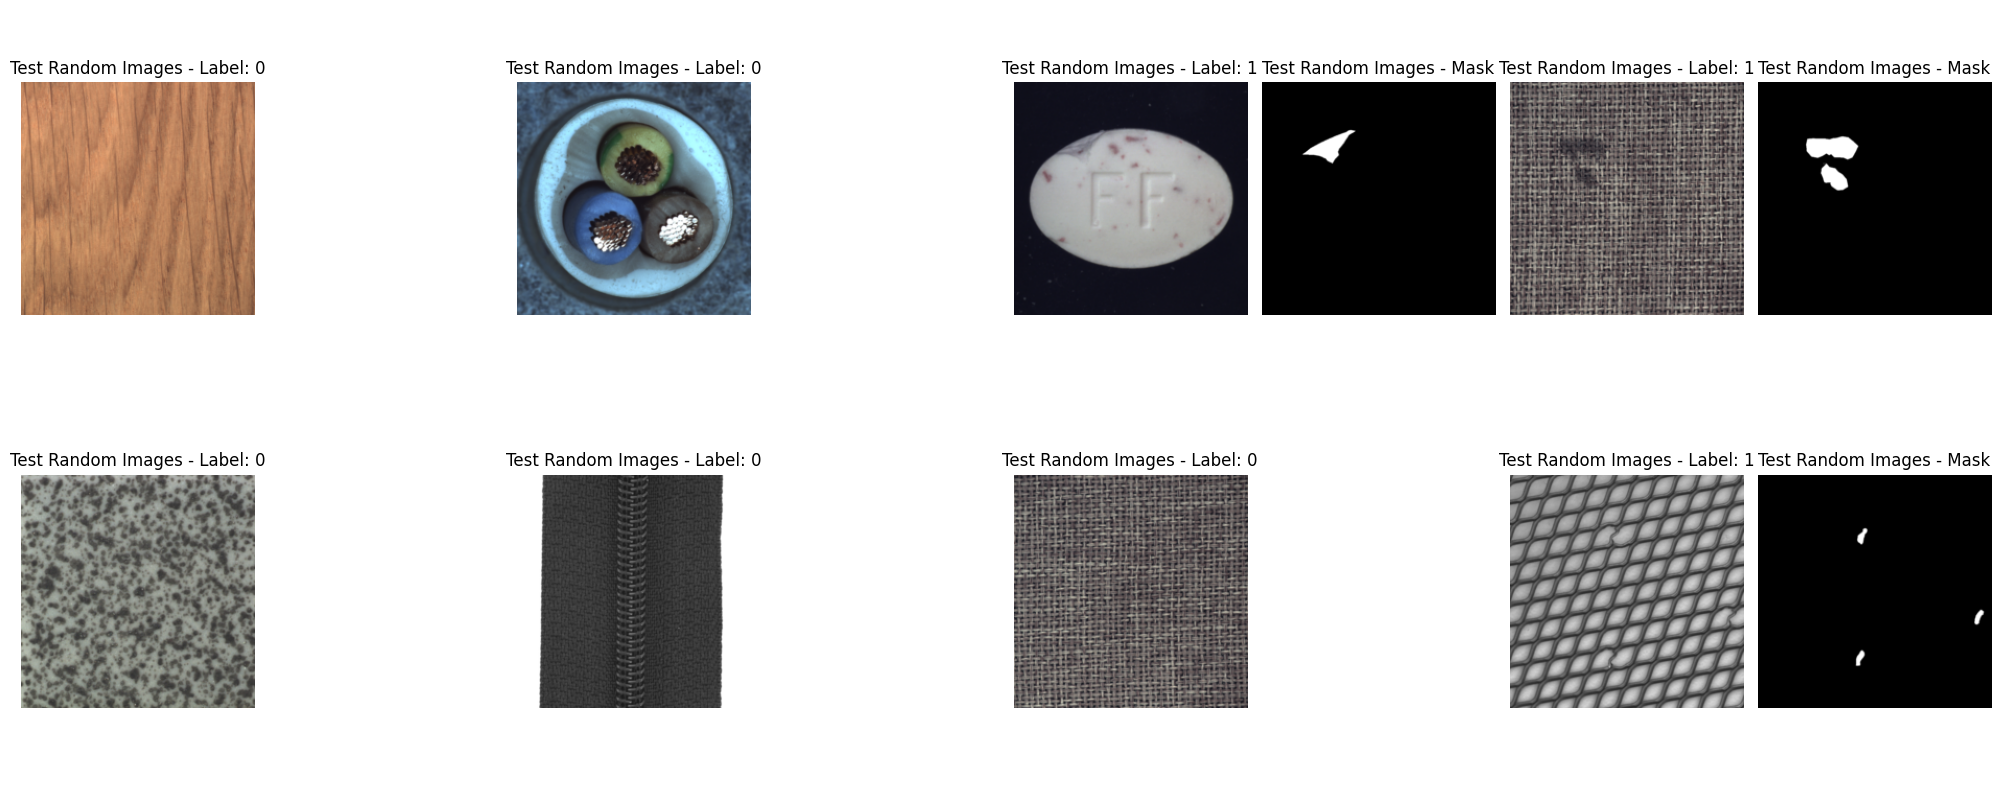

In [33]:
DATA_DIR = "data"
BATCH_SIZE = 32

data_module = MVTecDataModule(
    root_dir=DATA_DIR,
    batch_size=BATCH_SIZE,
    custom_collate_fn=custom_collate_fn,
    image_transform=image_transform,
    mask_transform=mask_transform,
)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

data_module.show_random_images(test_loader, "Test Random Images", num_images=8)

In [34]:
wandb.login(key="12eb3b5fb2e549363acfbb83b83bdd3330df09dc")
wandb_logger = WandbLogger(project="ReConPatch")

OUT_DIR = "."

TRAIN_MODEL = False

reconpatch = ReConPatch()
trainer = pl.Trainer(
    max_epochs=1,
    logger=wandb_logger,
    callbacks=[
        pl.callbacks.ModelCheckpoint(
            monitor="train_loss", save_top_k=1, mode="min", save_last=True
        ),
        pl.callbacks.EarlyStopping(monitor="train_loss", patience=10, mode="min"),
    ],
    devices=[0],
)

if TRAIN_MODEL:

    trainer.fit(model=reconpatch, datamodule=data_module)

    print("Training done, now filling the memory bank")
    reconpatch.fill_bank(train_loader)

    print("Memory bank filled, now obtaining the coreset")
    reconpatch.coreset_pruining()

    print("Coreset obtained, model can be used for inference now!")
    reconpatch.save_bank(f"{OUT_DIR}/memory_bank.pth")

    # close the wandb session
    wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/dario/.netrc


Using cache found in /home/dario/.cache/torch/hub/pytorch_vision_v0.13.0
/home/dario/repos/ReConPatch-torch/.recon/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dario/repos/ReConPatch-torch/.recon/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [49]:
LOAD_MODEL = True

if LOAD_MODEL:

    checkpoint_path = "best.ckpt"
    model = ReConPatch.load_from_checkpoint(checkpoint_path)

    model.load_bank(f"{OUT_DIR}/memory_bank.pth")

/home/dario/repos/ReConPatch-torch/.recon/lib/python3.12/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.3.0, which is newer than your current Lightning version: v2.2.5
Using cache found in /home/dario/.cache/torch/hub/pytorch_vision_v0.13.0
/home/dario/repos/ReConPatch-torch/.recon/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dario/repos/ReConPatch-torch/.recon/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings

In [50]:
scores = []
labels = []

with torch.no_grad():
    for sample in tqdm(test_loader):

        if len(sample) == 3:
            image, label, mask = sample
        else:
            image, label = sample
            mask = torch.zeros_like(image)

        score = model.anomaly_detection(image)

        scores.append(score)
        labels.append(label)

100%|██████████| 54/54 [06:22<00:00,  7.08s/it]


In [52]:
scores = torch.cat(scores).cpu().numpy()

In [53]:
labels = torch.cat(labels).cpu().numpy()

In [59]:
from sklearn.metrics import roc_auc_score

In [60]:
score = roc_auc_score(labels, scores)

In [61]:
score

0.47989569113136316

In [13]:
X = model.memory_bank.buffer

# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True)
X_pca = pca.fit_transform(X.detach().cpu().numpy())

pca3 = PCA(n_components=3, whiten=True)
X_pca3 = pca3.fit_transform(X.detach().cpu().numpy())

In [14]:
def visualize_2d(data, knn, coreset, pca, title=""):

    data_pca = pca.transform(data.cpu().numpy())
    knn_pca = pca.transform(knn.cpu().numpy())
    coreset_pca = pca.transform(coreset.cpu().numpy())

    plt.style.use("seaborn-v0_8-paper")
    plt.scatter(data_pca[:, 0], data_pca[:, 1], label="Test Sample", color="blue")
    plt.scatter(
        knn_pca[:, 0], knn_pca[:, 1], label="K Neighbours", color="red", marker="*"
    )
    plt.scatter(
        coreset_pca[:, 0], coreset_pca[:, 1], label="Coreset", color="green", alpha=0.2
    )

    plt.grid()
    plt.legend()
    plt.title(title)

    plt.show()


def visualize_3d(data, knn, coreset, pca, title=""):

    data_pca = pca.transform(data.cpu().numpy())
    knn_pca = pca.transform(knn.cpu().numpy())
    coreset_pca = pca.transform(coreset.cpu().numpy())

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(
        data_pca[:, 0],
        data_pca[:, 1],
        data_pca[:, 2],
        label="Test Sample",
        color="blue",
    )
    ax.scatter(
        knn_pca[:, 0],
        knn_pca[:, 1],
        knn_pca[:, 2],
        label="K Neighbours",
        color="red",
        marker="*",
        s=200,
    )
    ax.scatter(
        coreset_pca[:, 0],
        coreset_pca[:, 1],
        coreset_pca[:, 2],
        label="Coreset",
        color="green",
        alpha=1.0,
    )

    plt.grid()
    plt.legend()
    plt.title(title)

    plt.show()

In [12]:
x_rand = torch.randn(1, 3, 224, 224).to("cuda")

In [13]:
it = iter(test_loader)

In [14]:
x, y, z = next(it)

In [15]:
defective = x[0].unsqueeze(0)

In [16]:
defective.shape

torch.Size([1, 3, 224, 224])

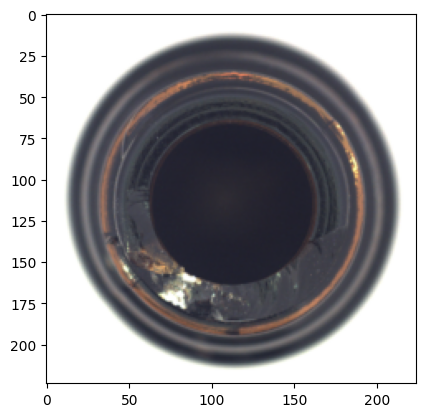

In [17]:
# show
plt.imshow(defective[0].permute(1, 2, 0).cpu().numpy())

In [18]:
fine = next(iter(train_loader))[0].to("cuda")

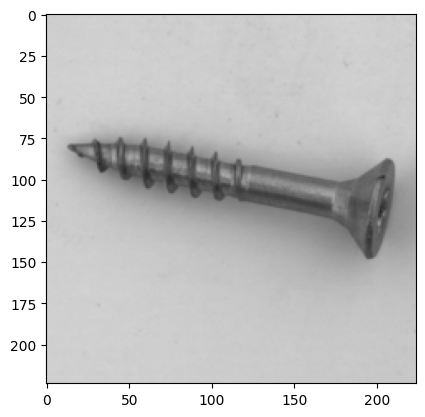

In [19]:
plt.imshow(fine[12].permute(1, 2, 0).cpu().numpy())

In [43]:
model.anomaly_detection(defective)

torch.Size([1, 784, 416])
torch.Size([1, 784, 1000])


tensor([-1.1513])

In [42]:
model.anomaly_detection(fine).max()

torch.Size([32, 784, 416])
torch.Size([32, 784, 1000])


tensor(2.7141)

In [ ]:
model.anomaly_detection(x_rand)

In [ ]:
repr_rand, knn_rand = model.anomaly_detection(x_rand)

In [ ]:
repr_def, knn_def = model.anomaly_detection(defective)

In [ ]:
repr_fine, knn_fine = model.anomaly_detection(fine)

In [ ]:
visualize_2d(repr_rand, knn_rand, X, pca, title="Random Image")
visualize_2d(repr_def, knn_def, X, pca, title="Defective Sample")
visualize_2d(repr_fine, knn_fine, X, pca, title="Normal Sample")

In [ ]:
from PIL import ImageFilter


def gaussian_blur(img):
    # Setup
    blur_kernel = ImageFilter.GaussianBlur(radius=4)
    tensor_to_pil = transforms.ToPILImage()
    pil_to_tensor = transforms.ToTensor()

    # Smoothing
    max_value = img.max().to("cpu")  # Maximum value of all elements in the image tensor
    blurred_pil = tensor_to_pil(img[0] / max_value).filter(blur_kernel)
    blurred_map = pil_to_tensor(blurred_pil) * max_value

    return blurred_map

In [ ]:
import torch
import torch.nn as nn


def anomalyDetection(batch_images, img_size):
    if batch_images.dim() == 3:
        batch_images = batch_images.unsqueeze(0)

    batch_size = batch_images.size(0)
    scores = []
    segm_maps = []

    for i in range(batch_size):
        image = batch_images[i].unsqueeze(0)

        with torch.no_grad():
            y = reconpatch(image)
        feature_map = reconpatch.fmap
        dimensions = (
            int(torch.Tensor([t.shape[-2] for t in feature_map]).max().item()),
            int(torch.Tensor([t.shape[-1] for t in feature_map]).max().item()),
        )

        blur = nn.AvgPool2d(3, stride=1)
        resizer = nn.AdaptiveAvgPool2d(dimensions)
        preprocess = lambda t: resizer(blur(t))
        feature_stacks = torch.cat([preprocess(m) for m in feature_map], dim=1)
        feature_stacks_reshaped = feature_stacks.reshape(
            feature_stacks.shape[1], -1
        ).T.to("cuda")

        # print(feature_stacks_reshaped.shape)
        # print(mem_bank.shape)

        distances = torch.cdist(feature_stacks_reshaped, mem_bank, p=2)

        dist_val, dist_val_idxs = torch.min(distances, dim=1)
        s_star = torch.max(dist_val)
        # distances shape = test_samples, mem_bank_samples
        m_star_idx = torch.argmin(torch.mean(distances, dim=0)).item()
        # print(m_star_idx.shape) #int
        m_test_star_idx = torch.argmax(distances[:, m_star_idx], dim=0)

        m_test_star = torch.unsqueeze(feature_stacks_reshaped[m_test_star_idx], dim=0)
        m_star = mem_bank[m_star_idx].unsqueeze(0)

        s_star = torch.cdist(m_test_star, m_star, p=2)
        # print(s_star)

        # m_test_star = torch.unsqueeze(feature_stacks_reshaped[s_idx], dim=0)
        # m_star = mem_bank[dist_val_idxs[s_idx]].unsqueeze(0)

        knn_dists = torch.cdist(m_star, mem_bank, p=2)
        _, nn_idxs = knn_dists.topk(k=3, largest=False)
        m_star_neighbourhood = mem_bank[nn_idxs[0, 1:]]

        # Update this part to use tensor operations instead of list comprehension
        diff_squares = torch.dist(m_test_star, m_star_neighbourhood, p=2)
        w_denominator = torch.sum(torch.exp(diff_squares), dim=0)

        # Normalize the distances to avoid large values
        w = 1 - (torch.exp(torch.dist(m_test_star, m_star, p=2)) / (w_denominator))
        s = w * s_star

        scores.append(s)

        # Define segmentation map
        fmap_size = feature_map[0].shape[-2:]
        segm_map = dist_val.view(1, 1, *fmap_size)
        segm_map = torch.nn.functional.interpolate(
            segm_map, size=(img_size, img_size), mode="bilinear"
        )
        segm_maps.append(gaussian_blur(segm_map))

    return torch.stack(scores), torch.stack(segm_maps)

In [ ]:
img_list = []
labels_list = []
pix_labels = []
pixel_prediction = []

for sample in tqdm(test_loader):

    if len(sample) == 3:
        img, label, mask = sample
        N = label.shape[0]
        new_mask = torch.zeros((N, 1, 224, 224))
        mask_index = 0
        mask_indices = label == 1
        new_mask[mask_indices] = mask

    else:
        img, label = sample
        new_mask = torch.zeros(label.shape[0], 1, 224, 224)
    pix_labels.extend(new_mask.flatten().numpy())
    img_size = img.shape[2]
    labels_list.append(label)
    probs, segmentation_map = anomalyDetection(img, img_size)

    pixel_prediction.extend(segmentation_map.flatten().numpy())

    probs = probs.to("cpu")
    img_list.append(probs)

In [ ]:
from sklearn.metrics import roc_auc_score

# img_list= n_batches x batch dim
# labels_list= n_batches x batch dim

labels_list = torch.cat(labels_list, dim=0)
img_list = torch.cat(img_list, dim=0)
img_list = img_list.squeeze().squeeze()

In [ ]:
res = roc_auc_score(labels_list, img_list)
print(res)

In [ ]:
pix_labels = np.array(pix_labels).astype(int)
pixel_res = roc_auc_score(pix_labels, pixel_prediction)
print(pixel_res)